Example of script to make a violin plot of number of UMI per spot.<br>

Input files are downsampled.<br>

data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/<br>
please download:<br>
10015CN108_C2_downsamp.tsv <br>
10015CN108_D2_downsamp.tsv <br>
10015CN108_E1_downsamp.tsv <br>
10015CN108fl_D1_downsamp.tsv <br>
10015CN108fl_D2_downsamp.tsv <br>
10015CN108fl_E2_downsamp.tsv <br>
10015CN90_C2_downsamp.tsv <br>
10015CN90_D2_downsamp.tsv <br>
10015CN90_E2_downsamp.tsv <br>
10015CN108_C2_stdata_under_tissue_IDs.txt <br>
10015CN108_D2_stdata_under_tissue_IDs.txt <br>
10015CN108_E1_stdata_under_tissue_IDs.txt <br>
10015CN108fl_D1_stdata_under_tissue_IDs.txt <br>
10015CN108fl_D2_stdata_under_tissue_IDs.txt <br>
10015CN108fl_E2_stdata_under_tissue_IDs.txt <br>
10015CN90_C2_stdata_under_tissue_IDs.txt <br>
10015CN90_D2_stdata_under_tissue_IDs.txt <br>
10015CN90_E2_stdata_under_tissue_IDs.txt <br>

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import matplotlib.patches as mpatches
import matplotlib
from matplotlib.text import Text
from matplotlib import transforms, lines
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties
from seaborn.utils import remove_na
from scipy import stats
from mlxtend.evaluate import permutation_test
DEFAULT = object()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
def stat_test(box_data1, box_data2, test):
    test_short_name = ''
    formatted_output = None
    if test == 'Wilcoxon':
        u_stat, pval = stats.ranksums(box_data1, box_data2)
        test_short_name = 'Wilcox'
        formatted_output = ("Wilcoxon test P_val={:.3e} U_stat={:.3e}"
                           .format(pval, u_stat))
        
    if test == 'ttest':
        u_stat, pval = stats.ttest_ind(box_data1, box_data2, equal_var=False)
        test_short_name = 'T-test'
        formatted_output = ("T-test P_val={:.3e} U_stat={:.3e}"
                           .format(pval, u_stat))
    if test == 'Perm-test':
        u_stat = 10000
        pval = permutation_test(box_data1, box_data2,
                            #func = 'x_mean > y_mean',
                           method='exact',
                           num_rounds=10000,
                           seed=0) 
        
    return pval, u_stat,formatted_output, test_short_name


def pval_annotation_text(x, pvalue_thresholds):
    singleValue = False
    if type(x) is np.array:
        x1 = x
    else:
        x1 = np.array([x])
        singleValue = True
    # Sort the threshold array
    pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
    x_annot = pd.Series(["" for _ in range(len(x1))])
    for i in range(0, len(pvalue_thresholds)):
        if (i < len(pvalue_thresholds)-1):
            condition = (x1 <= pvalue_thresholds[i][0]) & (pvalue_thresholds[i+1][0] < x1)
            x_annot[condition] = pvalue_thresholds[i][1]
        else:
            condition = x1 < pvalue_thresholds[i][0]
            x_annot[condition] = pvalue_thresholds[i][1]

    return x_annot if not singleValue else x_annot.iloc[0]


def simple_text(pval, pvalue_format, pvalue_thresholds, test_short_name=None):
    """
    Generates simple text for test name and pvalue
    :param pval: pvalue
    :param pvalue_format: format string for pvalue
    :param test_short_name: Short name of test to show
    :param pvalue_thresholds: String to display per pvalue range
    :return: simple annotation
    """
    # Sort thresholds
    thresholds = sorted(pvalue_thresholds, key=lambda x: x[0])

    # Test name if passed
    text = test_short_name and test_short_name + " " or ""

    for threshold in thresholds:
        if pval < threshold[0]:
            pval_text = "p ≤ {}".format(threshold[1])
            break
    else:
        pval_text = "p = {}".format(pvalue_format).format(pval)

    #return text + pval_text
    return pval_text


def add_stat_annotation(ax,
                        data=None, x=None, y=None, hue=None, order=None, hue_order=None,
                        box_pairs=None,
                        test='t-test_welch', text_format='star', pvalue_format_string=DEFAULT,
                        loc='inside', show_test_name=True, pvalue_thresholds=DEFAULT,
                        use_fixed_offset=False, line_offset_to_box=None, line_offset=None,
                        line_height=0.02, text_offset=1, stack=True,
                        color='0.2', linewidth=1.5, fontsize='medium', verbose=1):
    """
    User should use the same argument for the data, x, y, hue, order, hue_order as the seaborn boxplot function.
    line_height is in axes fraction coordinates.
    text_offset is in points.
    box_pairs can be of either form:
    For non-grouped boxplot: [(cat1, cat2), (cat3, cat4)]
    For boxplot grouped by hue: [((cat1, hue1), (cat2, hue2)), ((cat3, hue3), (cat4, hue4))]
    Default pvalue_format_string is "{.3e}".
    pvalue_thresholds is a list of lists or tuples. Default is:
    For "star" text_format:
        [[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]]
    For "simple" text_format :
        [[1e-5, "1e-5"], [1e-4, "1e-4"], [1e-3, "0.001"], [1e-2, "0.01"]]
    """

    def find_x_position_box(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        """
        if box_plotter.plot_hues is None:
            cat = boxName
            hueOffset = 0
        else:
            cat = boxName[0]
            hue = boxName[1]
            hueOffset = box_plotter.hue_offsets[box_plotter.hue_names.index(hue)]

        groupPos = box_plotter.group_names.index(cat)
        boxPos = groupPos + hueOffset
        return boxPos


    def get_box_data(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not direct access to the
        box_data in the BoxPlotter class.
        """
        if box_plotter.plot_hues is None:
            cat = boxName
        else:
            cat = boxName[0]
            hue = boxName[1]

        i = box_plotter.group_names.index(cat)
        group_data = box_plotter.plot_data[i]

        if box_plotter.plot_hues is None:
            # Draw a single box or a set of boxes
            # with a single level of grouping
            box_data = remove_na(group_data)
        else:
            hue_level = hue
            hue_mask = box_plotter.plot_hues[i] == hue_level
            box_data = remove_na(group_data[hue_mask])

        return box_data

    # Set default values if necessary
    if pvalue_format_string is DEFAULT:
        pvalue_format_string = '{:.3e}'
        simple_format_string = '{:.2f}'
    else:
        simple_format_string = pvalue_format_string

    if pvalue_thresholds is DEFAULT:
        if text_format == "star":
            pvalue_thresholds = [[1e-4, "****"], [1e-3, "***"],
                                 [1e-2, "**"], [0.05, "*"], [1, "ns"]]
        else:
            pvalue_thresholds = [[1e-5, "1e-5"], [1e-4, "1e-4"],
                                 [1e-3, "0.001"], [1e-2, "0.01"]]
    
    fig = plt.gcf()

    valid_list = ['inside', 'outside']
    if loc not in valid_list:
        raise ValueError("loc value should be one of the following: {}.".format(', '.join(valid_list)))
    valid_list = ['Wilcoxon', 'ttest', 'Perm-test']
    if test not in valid_list:
        raise ValueError("test value should be one of the following: {}.".format(', '.join(valid_list)))

    if verbose >= 1 and text_format == 'star':
        print("pvalue annotation legend:")
        pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
        for i in range(0, len(pvalue_thresholds)):
            if (i < len(pvalue_thresholds)-1):
                print('{}: {:.2e} < p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i+1][0], pvalue_thresholds[i][0]))
            else:
                print('{}: p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i][0]))
        print()

    # Create the same BoxPlotter object as seaborn's boxplot
    box_plotter = sns.categorical._BoxPlotter(x, y, hue, data, order, hue_order,
                                              orient=None, width=.8, color=None, palette=None, saturation=.75,
                                              dodge=True, fliersize=5, linewidth=None)
    print(box_plotter.group_names, box_plotter.hue_names)
    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]

    if line_offset is None:
        if loc == 'inside':
            line_offset = 0.05
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset = 0.03
            line_offset_to_box = line_offset
    else:
        if loc == 'inside':
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset_to_box = line_offset
    y_offset = line_offset*yrange
    y_offset_to_box = line_offset_to_box*yrange

    y_stack = []
    annList = []
    test_result_list = []
    for box1, box2 in box_pairs:

        valid = None
        group_names = box_plotter.group_names
        hue_names = box_plotter.hue_names
        if box_plotter.plot_hues is None:
            cat1 = box1
            cat2 = box2
            hue1 = None
            hue2 = None
            label1 = '{}'.format(cat1)
            label2 = '{}'.format(cat2)
            valid = cat1 in group_names and cat2 in group_names
        else:
            cat1 = box1[0]
            hue1 = box1[1]
            cat2 = box2[0]
            hue2 = box2[1]
            label1 = '{}_{}'.format(cat1, hue1)
            label2 = '{}_{}'.format(cat2, hue2)
            valid = cat1 in group_names and cat2 in group_names and hue1 in hue_names and hue2 in hue_names

        if valid:
            # Get position of boxes
            x1 = find_x_position_box(box_plotter, box1)
            x2 = find_x_position_box(box_plotter, box2)
            box_data1 = get_box_data(box_plotter, box1)
            box_data2 = get_box_data(box_plotter, box2)
            ymax1 = box_data1.max()
            ymax2 = box_data2.max()

            pval, u_stat,formatted_output, test_short_name = stat_test(box_data1, box_data2, test)
            test_result_list.append({'pvalue':pval, 'test_short_name':test_short_name,
                                   'formatted_output':formatted_output, 'box1':box1, 'box2':box2})
            if verbose >= 1:
                print("{} v.s. {}: {}".format(label1, label2, formatted_output))

            if text_format == 'full':
                text = "{} p = {}".format('{}', pvalue_format_string).format(test_short_name, pval)
            elif text_format is None:
                text = None
            elif text_format is 'star':
                text = pval_annotation_text(pval, pvalue_thresholds)
            elif text_format is 'simple':
                test_short_name = show_test_name and test_short_name or ""
                text = simple_text(pval, simple_format_string, pvalue_thresholds,
                                   test_short_name)

            if loc == 'inside':
                yref = max(ymax1, ymax2)
            elif loc == 'outside':
                yref = ylim[1]

            if stack:
                if len(y_stack) > 0:
                    yref2 = max(yref, max(y_stack))
                else:
                    yref2 = yref
            else:
                yref2 = yref

            if len(y_stack) == 0:
                y = yref2 + y_offset_to_box
            else:
                y = yref2 + y_offset
            h = line_height*yrange
            lineX, lineY = [x1, x1, x2, x2], [y, y + h, y + h, y]
            if loc == 'inside':
                ax.plot(lineX, lineY, lw=linewidth, c=color)
            elif loc == 'outside':
                line = lines.Line2D(lineX, lineY, lw=linewidth, c=color, transform=ax.transData)
                line.set_clip_on(False)
                ax.add_line(line)

            if text is not None:
                ann = ax.annotate(text, xy=(np.mean([x1, x2]), y + h),
                                  xytext=(0, text_offset), textcoords='offset points',
                                  xycoords='data', ha='center', va='bottom', fontsize=fontsize,
                                  clip_on=False, annotation_clip=False)
                annList.append(ann)

            ax.set_ylim((ylim[0], 1.1*(y + h)))

            if text is not None:
                plt.draw()
                y_top_annot = None
                got_mpl_error = False
                if not use_fixed_offset:
                    try:
                        bbox = ann.get_window_extent()
                        bbox_data = bbox.transformed(ax.transData.inverted())
                        y_top_annot = bbox_data.ymax
                    except RuntimeError:
                        got_mpl_error = True

                if use_fixed_offset or got_mpl_error:
                    if verbose >= 1:
                        print("Warning: cannot get the text bounding box. Falling back to a fixed y offset. Layout may be not optimal.")
                    # We will apply a fixed offset in points, based on the font size of the annotation.
                    fontsize_points = FontProperties(size='medium').get_size_in_points()
                    offsetTrans = mtransforms.offset_copy(ax.transData, fig=fig,
                                                          x=0, y=1.0*fontsize_points + text_offset, units='points')
                    yTopDisplay = offsetTrans.transform((0, y + h))
                    y_top_annot = ax.transData.inverted().transform(yTopDisplay)[1]
            else:
                y_top_annot = y + h

            y_stack.append(y_top_annot)
        else:
            raise ValueError("box_pairs contains an unvalid box pair.")
            pass

    y_stack_max = max(y_stack)
    if loc == 'inside':
        ax.set_ylim((ylim[0], 1.03*y_stack_max))
    elif loc == 'outside':
        ax.set_ylim((ylim[0], ylim[1]))

    return ax, test_result_list

In [4]:
def condition(row):
    """ Takes row in pandas df as input and returns type of condition
    
    """
    # The samples are run in triplicate based on condition
    condition = ['HE', 'DAPI', 'Nestin']

    if row['index'] in ['10015CN108fl_D1', '10015CN108fl_D2', '10015CN108fl_E2']: 
        return condition[2]
        
    elif row['index'] in ['10015CN90_C2', '10015CN90_D2', '10015CN90_E2']:
        return condition[1]
    
    elif row['index'] in ['10015CN108_C2', '10015CN108_D2', '10015CN108_E1']:
        return condition[0]
        

In [5]:
# Load input files, tsv files from st-pipeline

path = '../../smomics_data'

files_dict = {}
tmp = list()

filez = ['10015CN108fl_D2_downsamp.tsv',
         '10015CN108fl_E2_downsamp.tsv',
         '10015CN108fl_D1_downsamp.tsv',
         '10015CN90_C2_downsamp.tsv',
         '10015CN90_D2_downsamp.tsv',
         '10015CN90_E2_downsamp.tsv',
        '10015CN108_C2_downsamp.tsv',
         '10015CN108_D2_downsamp.tsv',
         '10015CN108_E1_downsamp.tsv'] 

# First is to get all the names in order
for z in filez:
    filename = os.path.join(path, z)
    tmp.append(filename)
tmp.sort()
    
for filename in tmp:
    
    # Store file name
    name = '_'.join([filename.split('/')[-1].split('_')[0], filename.split('/')[-1].split('_')[1]])
    
    file = pd.read_csv(filename, sep = '\t', index_col=0)

    files_dict[name] = file.T
    


In [6]:
# I only want to look at spots under tissue so I pick the spots from the *stdata_under_tissue_IDs.txt files

samples_list = ['10015CN108fl_D1', '10015CN108fl_D2', '10015CN108fl_E2',
               '10015CN90_C2', '10015CN90_D2', '10015CN90_E2',
               '10015CN108_C2', '10015CN108_D2', '10015CN108_E1']

# SPots under tissue
path_spots = '../../smomics_data'

genes_under_tissue_dict = {}
tmp = list()

# First is to get all the names in order
for filename in glob.glob(os.path.join(path_spots, '*_IDs.txt')):
    tmp.append(filename)
tmp.sort()
    
for filename in tmp:
    
    # Store file name
    # Example name: 10015CN84_D1_stdata_under_tissue_IDs.txt
    name = '_'.join([filename.split('/')[-1].split('_')[0], filename.split('/')[-1].split('_')[1]])
        
    #print(name)
    
    file = pd.read_csv(filename, sep = '\t', index_col=0)
    
    spot_coord = list()
    
    # if spot coordinates in float...
    if len(list(file)[0].split('.')) == 3:
        for spots in list(file):
            spot_tmp = [ float(elem) for elem in spots.split('_') ]
            spot_tmp2 = [ round(elem, 0) for elem in spot_tmp ]
            spot_tmp3 = [ int(elem) for elem in spot_tmp2 ]

            new_spot_coord = str(spot_tmp3[0]) + 'x' + str(spot_tmp3[1])
            spot_coord.append(new_spot_coord)
    else:
        for spots in list(file):
            spots_tmp = spots.split('_')
            new_spot_coord = str(spots_tmp[0]) + 'x' + str(spots_tmp[1])   
            spot_coord.append(new_spot_coord)
        
    # Only store those samples I am interested in
    if name in samples_list:
        genes_under_tissue_dict[name] = spot_coord
        print(name, len(spot_coord))


10015CN108_C2 611
10015CN108_D2 672
10015CN108_E1 602
10015CN108fl_D1 547
10015CN108fl_D2 539
10015CN108fl_E2 562
10015CN90_C2 737
10015CN90_D2 705
10015CN90_E2 691


In [7]:
# Since I didn't have the *stdata_under_tissue.txt file for 10015CN108fl_D1 I had to use the annotation file:

D1annot = '../../smomics_data/10015CN108fl_D1_annotations.txt'

# Store file name
D1name = '_'.join([D1annot.split('/')[-1].split('_')[0], D1annot.split('/')[-1].split('_')[1]])

file = pd.read_csv(D1annot, sep = '\t', index_col=0)

xy = []
for spots in file['x_y'].tolist():
    spot_tmp = [ float(elem) for elem in spots.split('_') ]
    spot_tmp2 = [ round(elem, 0) for elem in spot_tmp ]
    spot_tmp3 = [ int(elem) for elem in spot_tmp2 ]

    new_spot_coord = str(spot_tmp3[0]) + 'x' + str(spot_tmp3[1])
    xy.append(new_spot_coord)
print(xy[0:5])

genes_under_tissue_dict[D1name] = xy


['32x24', '21x9', '24x7', '28x6', '29x20']


In [8]:
# Separate spots if they are under or outside of tissue

files_underoutside_tissue_dict = {}

for k, v in files_dict.items():
    #print(v.shape)
    
    v_under_tissue = v[genes_under_tissue_dict[k]]
    
    # Spots outside of tissue
    spots_outside_tissue = [x for x in list(v) if x not in list(v_under_tissue)]
    print(len(spots_outside_tissue))
    v
    v_outside_tissue = v[spots_outside_tissue] 
    
    #print(v_under_tissue.shape)
    #print(v_outside_tissue.shape)
    
    files_underoutside_tissue_dict[k] = [v_under_tissue, v_outside_tissue]

392
325
373
445
462
438
270
302
316


In [9]:
# Make a sample-condition dictionary
sam_cond = {'Nestin': ['10015CN108fl_D1', '10015CN108fl_D2', '10015CN108fl_E2'], #'10015CN108fl_D1'
           'DAPI':['10015CN90_C2', '10015CN90_D2', '10015CN90_E2'], 
           'HE':['10015CN108_C2', '10015CN108_D2', '10015CN108_E1']}

In [10]:
# Seq depth adjustments == cutoffs to call a gene
seq_depth = {'10015CN108fl_D1':[49494158, 49],
            '10015CN108fl_D2':[25894163, 25.9],
            '10015CN108fl_E2':[85685215, 85.7],
            '10015CN90_C2':[76553415, 76.6],
            '10015CN90_D2':[67707512, 67.7],
            '10015CN90_E2': [67041671, 67],
            '10015CN108_C2':[39322470, 39.3],
            '10015CN108_D2':[25293514, 25.3],
            '10015CN108_E1':[34784629, 34.8]}

gene_dict = {}

for key, value in files_underoutside_tissue_dict.items():
    
    for i, val in enumerate(value): # [inside/outside] of tissue    
        # Sum the counts for each gene
        val['tot count'] = val.sum(axis=1)
    
        # # Remove genes (rows) where the total sum is less than xx
        v2 = val[val['tot count'] > seq_depth[key][1]]
    
        # Sum the counts for all genes
        tot_sum = v2['tot count'].to_numpy().sum() 
        
        # Normalize per spot
        norm_tot_sum = tot_sum / (val.shape[1]-1)
    
        ###########################################################
        # change values which are under cutoff to 0
        #v2 = value.mask(value < seq_depth[key][1], 0)

        # Sum the counts for all genes
        #tot_sum = v2.to_numpy().sum() 
        ###########################################################    
        if i == 0: # inside tissue
            gene_dict[key] = [norm_tot_sum]
        elif i == 1: # outside tissue
            gene_dict[key].append(norm_tot_sum)
    
# Make dataframe out of dict
df = pd.DataFrame.from_dict(gene_dict, orient='index', columns=['UMI inside', 'UMI outside']).reset_index()
df['Condition'] = df.apply(lambda row: condition(row), axis=1)

# Prepare for plotting
dfplot = pd.melt(df, id_vars=['index', 'Condition'], value_vars = ['UMI inside', 'UMI outside'])

print(df)
print(dfplot.head())

             index   UMI inside  UMI outside Condition
0    10015CN108_C2  5441.140753  1816.329082        HE
1    10015CN108_D2  5152.532738  1749.489231        HE
2    10015CN108_E1  5715.950166  2156.959786        HE
3  10015CN108fl_D1  3149.725777   379.321348    Nestin
4  10015CN108fl_D2  3920.933210  1045.175325    Nestin
5  10015CN108fl_E2  9360.895018  1850.472603    Nestin
6     10015CN90_C2  6990.812754  1470.918519      DAPI
7     10015CN90_D2  7866.626950  2887.592715      DAPI
8     10015CN90_E2  9513.668596  3362.658228      DAPI
             index Condition    variable        value
0    10015CN108_C2        HE  UMI inside  5441.140753
1    10015CN108_D2        HE  UMI inside  5152.532738
2    10015CN108_E1        HE  UMI inside  5715.950166
3  10015CN108fl_D1    Nestin  UMI inside  3149.725777
4  10015CN108fl_D2    Nestin  UMI inside  3920.933210


['UMI inside', 'UMI outside'] ['HE', 'DAPI', 'Nestin']
UMI inside_HE v.s. UMI inside_DAPI: None
UMI inside_HE v.s. UMI inside_Nestin: None
UMI inside_DAPI v.s. UMI inside_Nestin: None
UMI outside_HE v.s. UMI outside_DAPI: None
UMI outside_HE v.s. UMI outside_Nestin: None
UMI outside_Nestin v.s. UMI outside_DAPI: None


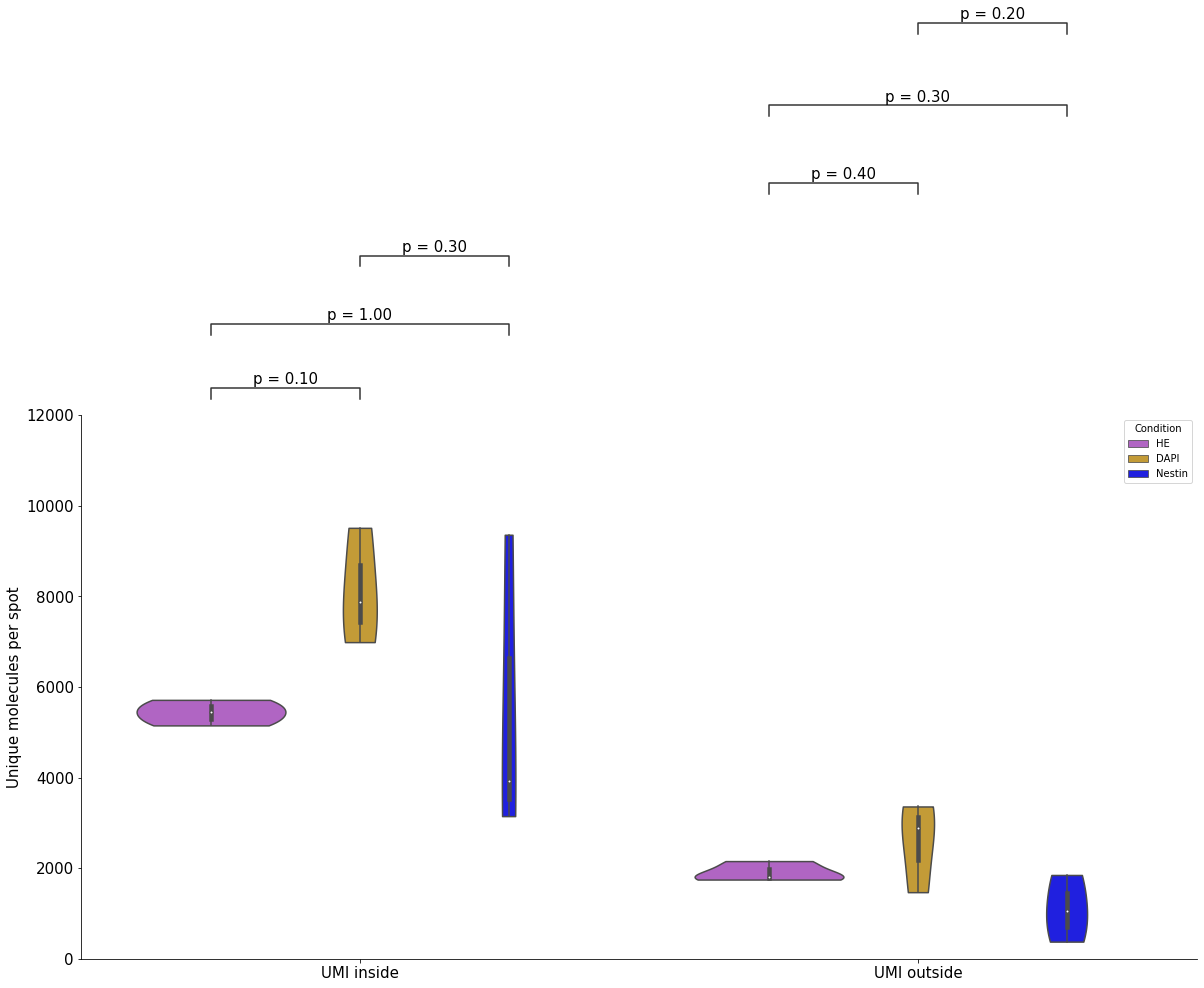

In [19]:
# Plot
fig = plt.figure(figsize=(15, 5)) 

x='variable'
y='value'
hue = 'Condition'
data=dfplot

ax = sns.violinplot(x=x, y=y, data=data, hue=hue, order=['UMI inside', 'UMI outside'], hue_order=['HE', 'DAPI', 'Nestin'], palette = ['mediumorchid', 'goldenrod', 'blue'], cut=0)

# change background color
back_c = 'white'
ax.set_facecolor(back_c)
ax.grid(False)
#frame = leg.get_frame()
#frame.set_facecolor(back_c)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('k')
ax.spines['left'].set_color('k')

# X and y label size
ax.set_xlabel("")
ax.set_ylabel("Unique molecules per spot", fontsize=15)
ax.set_ylim([0,12000])
# x and y ticks
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

# Calculate T-test 
boxPairList = [(('UMI inside', 'HE'), ('UMI inside', 'DAPI')),
               (('UMI inside', 'HE'), ('UMI inside', 'Nestin')),
               (('UMI inside', 'DAPI'), ('UMI inside', 'Nestin')),
               (('UMI outside', 'HE'), ('UMI outside', 'DAPI')),
              (('UMI outside', 'HE'), ('UMI outside', 'Nestin')),
              (('UMI outside', 'Nestin'), ('UMI outside', 'DAPI'))]

add_stat_annotation(ax, data=data, x=x, y=y, hue=hue, order = ['UMI inside', 'UMI outside'], hue_order=['HE', 'DAPI', 'Nestin'],
                    box_pairs=boxPairList,
                    test='Perm-test', text_format='simple', loc='outside', verbose=2, fontsize=15)

fig.set_size_inches(20, 10)
# plt.savefig("../../figures/umiHEDAPINestin.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)
plt.show()